In [1]:
# @title 1. Setup and Configuration for MoCo
# This cell handles imports and defines global configurations.

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# NOTE: Adjust BATCH_SIZE if you encounter out-of-memory errors.
BATCH_SIZE = 64
EPOCHS_PRETRAIN = 50 # As requested
EPOCHS_LINEAR_EVAL = 50
LEARNING_RATE = 0.03 # As per MoCo paper for SGD
WEIGHT_DECAY = 1e-4
MOMENTUM_SGD = 0.9 # SGD momentum

# --- MoCo Specific Hyperparameters ---
PROJECTION_DIM = 128 # Dimension of the projection head output, as per MoCo paper
MOMENTUM_ENCODER = 0.999 # Momentum for the key encoder update
TEMPERATURE = 0.07    # Temperature for the InfoNCE loss
QUEUE_SIZE_K = 65536  # Size of the dictionary queue

# --- General Setup ---
NUM_WORKERS = 2
NUM_CLASSES = 4 # Dark, Green, Light, Medium coffee beans
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Path to save models/plots in the Kaggle environment
SAVE_DIR = "/kaggle/working/moco_coffee_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [2]:
# @title 2. MoCo Data Augmentations and Loading
# This cell defines the data augmentation pipeline and loads the dataset.

# --- Data Augmentations for MoCo (Two-Crop Transform) ---
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# MoCo uses a specific set of augmentations
moco_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Define Kaggle Data Paths ---
DATA_DIR = "/kaggle/input/coffee-bean-dataset-resized-224-x-224"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# --- Create Datasets and DataLoaders ---

# Dataset for MoCo self-supervised pre-training
train_dataset_moco = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=TwoCropTransform(moco_transform)
)
train_loader_moco = DataLoader(train_dataset_moco, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

# Datasets for linear evaluation (using standard augmentations)
train_transform_eval = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_eval = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform_eval)
test_dataset_eval = datasets.ImageFolder(root=TEST_DIR, transform=test_transform_eval)

train_loader_eval = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

print(f"MoCo pre-training dataset size: {len(train_dataset_moco)}")
print(f"Linear evaluation training dataset size: {len(train_dataset_eval)}")
print(f"Linear evaluation test dataset size: {len(test_dataset_eval)}")

MoCo pre-training dataset size: 1200
Linear evaluation training dataset size: 1200
Linear evaluation test dataset size: 400


In [3]:
# @title 3. MoCo Model Implementation
# This cell defines the full MoCo model architecture.

class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=PROJECTION_DIM, K=QUEUE_SIZE_K, m=MOMENTUM_ENCODER, T=TEMPERATURE):
        super(MoCo, self).__init__()
        self.K = K
        self.m = m
        self.T = T

        # Create the encoders
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        # Initialize the key encoder to be the same as the query encoder
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False # Key encoder is not updated by gradients

        # Create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update of the key encoder."""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        
        # Ensure the queue is not too small for the batch
        assert self.K % batch_size == 0
        
        # Replace the keys at ptr
        self.queue[:, ptr : ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # Move pointer
        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle(self, x):
        """Shuffle batch for BN to prevent cheating"""
        batch_size = x.shape[0]
        idx_shuffle = torch.randperm(batch_size).to(DEVICE)
        idx_unshuffle = torch.argsort(idx_shuffle)
        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle(self, x, idx_unshuffle):
        """Undo shuffling"""
        return x[idx_unshuffle]

    def forward(self, im_q, im_k):
        # 1. Compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = F.normalize(q, dim=1)

        # 2. Compute key features (with momentum encoder and no gradients)
        with torch.no_grad():
            self._momentum_update_key_encoder() # Update the key encoder
            
            # Shuffle keys for BN
            im_k, idx_unshuffle = self._batch_shuffle(im_k)
            k = self.encoder_k(im_k) # keys: NxC
            k = F.normalize(k, dim=1)
            
            # Unshuffle keys
            k = self._batch_unshuffle(k, idx_unshuffle)

        # 3. Compute logits
        # Positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        # Labels: positives are the 0-th index
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

        # 4. Dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels

# Define the base encoder (ResNet-50)
def resnet50_encoder(num_classes):
    model = models.resnet50(weights=None, num_classes=num_classes)
    return model

# Instantiate the MoCo model
moco_model = MoCo(base_encoder=resnet50_encoder).to(DEVICE)
print("MoCo model created.")

MoCo model created.


In [4]:
# @title 4. Self-Supervised Pre-training Loop for MoCo
# This cell contains the main pre-training logic for MoCo.

print("--- Starting MoCo Self-Supervised Pre-training ---\n")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(moco_model.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

pretrain_losses = []

for epoch in range(1, EPOCHS_PRETRAIN + 1):
    moco_model.train()
    total_loss = 0.0
    start_time = time.time()

    for images, _ in train_loader_moco:
        im_q, im_k = images[0].to(DEVICE), images[1].to(DEVICE)

        # Forward pass
        output, target = moco_model(im_q, im_k)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_moco)
    pretrain_losses.append(avg_loss)
    elapsed_time = time.time() - start_time
    print(f"Pretrain Epoch {epoch}/{EPOCHS_PRETRAIN} | Loss: {avg_loss:.4f} | Time: {elapsed_time:.1f}s")

print("\n--- MoCo Self-Supervised Pre-training Finished ---\n")

# Save the pre-trained query encoder
encoder_path = os.path.join(SAVE_DIR, "moco_encoder_coffee.pth")
torch.save(moco_model.encoder_q.state_dict(), encoder_path)
print(f"Saved pre-trained encoder to {encoder_path}")

--- Starting MoCo Self-Supervised Pre-training ---

Pretrain Epoch 1/50 | Loss: 5.7805 | Time: 17.7s
Pretrain Epoch 2/50 | Loss: 6.7963 | Time: 16.2s
Pretrain Epoch 3/50 | Loss: 6.5699 | Time: 16.6s
Pretrain Epoch 4/50 | Loss: 6.5280 | Time: 17.2s
Pretrain Epoch 5/50 | Loss: 6.5514 | Time: 18.3s
Pretrain Epoch 6/50 | Loss: 6.6023 | Time: 18.4s
Pretrain Epoch 7/50 | Loss: 6.6546 | Time: 17.8s
Pretrain Epoch 8/50 | Loss: 6.7063 | Time: 17.5s
Pretrain Epoch 9/50 | Loss: 6.7599 | Time: 17.6s
Pretrain Epoch 10/50 | Loss: 6.8062 | Time: 17.8s
Pretrain Epoch 11/50 | Loss: 6.8494 | Time: 17.8s
Pretrain Epoch 12/50 | Loss: 6.8896 | Time: 17.8s
Pretrain Epoch 13/50 | Loss: 6.9275 | Time: 17.9s
Pretrain Epoch 14/50 | Loss: 6.9580 | Time: 18.0s
Pretrain Epoch 15/50 | Loss: 6.9956 | Time: 18.1s
Pretrain Epoch 16/50 | Loss: 7.0302 | Time: 17.9s
Pretrain Epoch 17/50 | Loss: 7.0696 | Time: 17.9s
Pretrain Epoch 18/50 | Loss: 7.0874 | Time: 17.8s
Pretrain Epoch 19/50 | Loss: 7.1128 | Time: 17.8s
Pretrai

In [5]:
# @title 5. Linear Evaluation (Downstream Task)
# This cell evaluates the pre-trained MoCo encoder.

class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        # The base ResNet-50 from MoCo will output feature_dim directly
        # We just need a final linear layer.
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

print("\n--- Starting Linear Evaluation ---\n")

# The base encoder used for MoCo outputs 2048 features before the projector
# So, for linear evaluation, we load a standard ResNet-50
base_encoder_eval = models.resnet50(weights=None)
# We need to load the weights from our trained encoder_q
# We will create a new state_dict that matches the base_encoder structure
encoder_q_state_dict = torch.load(encoder_path, map_location=DEVICE)
# Remove the projector head ('fc') layers from the saved state dict
for k in list(encoder_q_state_dict.keys()):
    if k.startswith('fc'):
        del encoder_q_state_dict[k]
        
base_encoder_eval.load_state_dict(encoder_q_state_dict, strict=False)
# The feature dimension is the input to the original fc layer
feature_dim_eval = base_encoder_eval.fc.in_features
# We replace the fc layer for our evaluation classifier
base_encoder_eval.fc = nn.Identity() # The encoder will output features directly

pretrained_encoder = base_encoder_eval.to(DEVICE)
for param in pretrained_encoder.parameters():
    param.requires_grad = False

# Attach classifier
classifier = LinearClassifier(feature_dim_eval, num_classes=NUM_CLASSES).to(DEVICE)

# Training setup
optimizer_eval = optim.Adam(classifier.parameters(), lr=LEARNING_RATE) # Adam is fine for the classifier
criterion_eval = nn.CrossEntropyLoss()
linear_eval_test_accuracies = []

# Main training loop
for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    classifier.train()
    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_eval.zero_grad()
        with torch.no_grad():
            features = pretrained_encoder(images)
        outputs = classifier(features)
        loss = criterion_eval(outputs, labels)
        loss.backward()
        optimizer_eval.step()

    # Evaluation
    classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = pretrained_encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    linear_eval_test_accuracies.append(accuracy)
    print(f"Linear Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Test Acc: {accuracy:.2f}%")

print("\n--- Linear Evaluation Finished ---\n")


--- Starting Linear Evaluation ---

Linear Eval Epoch 1/50 | Test Acc: 34.50%
Linear Eval Epoch 2/50 | Test Acc: 31.75%
Linear Eval Epoch 3/50 | Test Acc: 35.50%
Linear Eval Epoch 4/50 | Test Acc: 32.75%
Linear Eval Epoch 5/50 | Test Acc: 35.75%
Linear Eval Epoch 6/50 | Test Acc: 36.75%
Linear Eval Epoch 7/50 | Test Acc: 33.00%
Linear Eval Epoch 8/50 | Test Acc: 35.00%
Linear Eval Epoch 9/50 | Test Acc: 36.50%
Linear Eval Epoch 10/50 | Test Acc: 32.25%
Linear Eval Epoch 11/50 | Test Acc: 35.25%
Linear Eval Epoch 12/50 | Test Acc: 35.25%
Linear Eval Epoch 13/50 | Test Acc: 34.25%
Linear Eval Epoch 14/50 | Test Acc: 30.75%
Linear Eval Epoch 15/50 | Test Acc: 36.50%
Linear Eval Epoch 16/50 | Test Acc: 32.75%
Linear Eval Epoch 17/50 | Test Acc: 31.00%
Linear Eval Epoch 18/50 | Test Acc: 32.50%
Linear Eval Epoch 19/50 | Test Acc: 35.50%
Linear Eval Epoch 20/50 | Test Acc: 34.25%
Linear Eval Epoch 21/50 | Test Acc: 32.25%
Linear Eval Epoch 22/50 | Test Acc: 33.25%
Linear Eval Epoch 23/50 | 

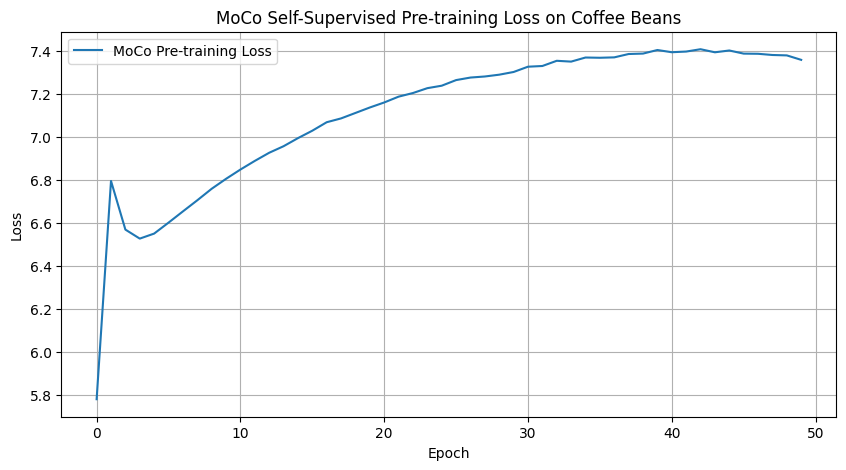

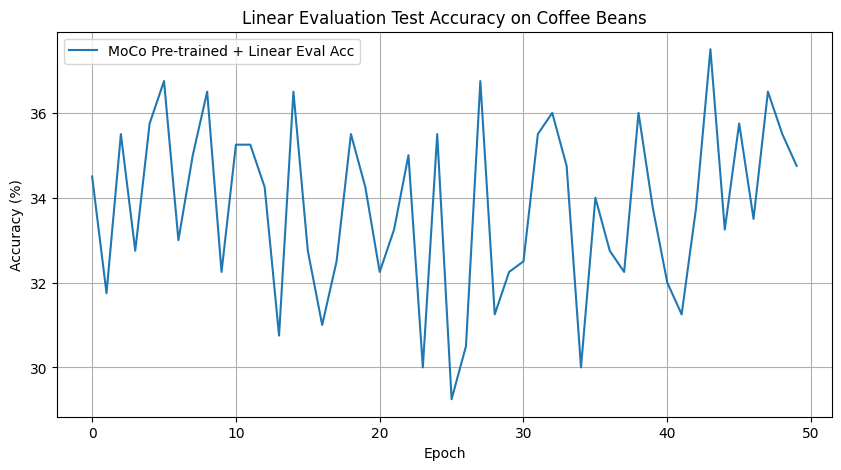


--- Visualizing Embedding Space with t-SNE ---

Running t-SNE on 400 embeddings...


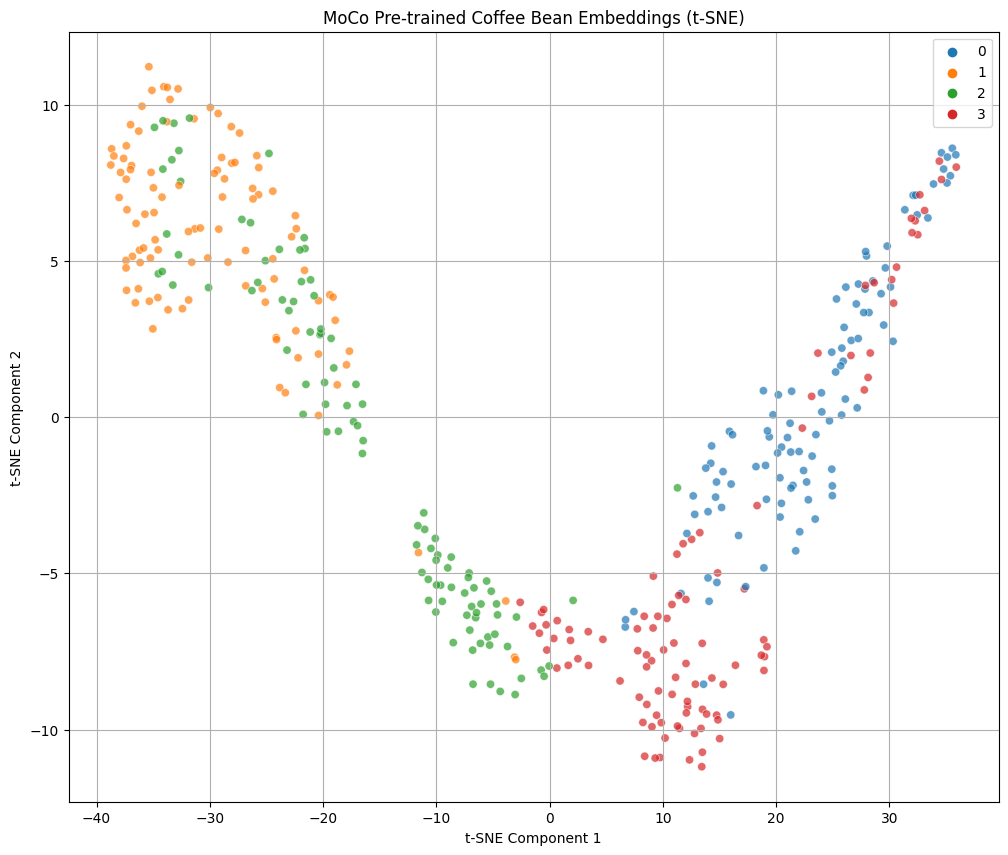

In [6]:
# @title 6. Visualization of Impact
# This cell visualizes the training loss and embedding space.

# --- Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses, label='MoCo Pre-training Loss')
plt.title('MoCo Self-Supervised Pre-training Loss on Coffee Beans')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "moco_pretrain_loss_coffee.png"))
plt.show()

# --- Accuracy Curve ---
plt.figure(figsize=(10, 5))
plt.plot(linear_eval_test_accuracies, label='MoCo Pre-trained + Linear Eval Acc')
plt.title('Linear Evaluation Test Accuracy on Coffee Beans')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "linear_eval_accuracy_coffee.png"))
plt.show()

# --- Embedding Space Visualization (t-SNE) ---
print("\n--- Visualizing Embedding Space with t-SNE ---\n")

# Use a subset of the test set
num_samples_tsne = min(1000, len(test_dataset_eval))
subset_indices = np.random.choice(len(test_dataset_eval), num_samples_tsne, replace=False)
subset_dataset_eval = torch.utils.data.Subset(test_dataset_eval, subset_indices)
subset_loader_eval = DataLoader(subset_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pretrained_encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in subset_loader_eval:
        images = images.to(DEVICE)
        features = pretrained_encoder(images)
        embeddings.append(features.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)

print(f"Running t-SNE on {embeddings.shape[0]} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=labels, palette=sns.color_palette("tab10", NUM_CLASSES),
    legend='full', alpha=0.7
)
plt.title('MoCo Pre-trained Coffee Bean Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "moco_embeddings_tsne_coffee.png"))
plt.show()